# Auspendleranteil

### Dataset

https://www.data.gv.at/katalog/de/dataset/stat_gemeindeergebnisse-der-abgestimmten-erwerbsstatistik-und-arbeitsstattenzahlung-ab-20-31-10

- Gemeindelevel (inklusive Bezirkslevel Wien)
- 2011-2022

= Auspendleranteil:
- AUSPENDLER = Auspendler:innenanteil (Anteil der Auspendler:innen an den Erwerbstätigen am Wohnort)

## Prepare Data

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
# Read the employment statistics CSV; skip no rows since header is on first line
erw = pd.read_csv("../data_arima_raw/erwerbsstatistik.csv", sep=";")

# Keep only the year, district code (GCD), and the AUSPENDLER percentage
erw = erw[["JAHR", "GCD", "AUSPENDLER"]].copy()

# Filter to Vienna districts (GCD between 90101 and 92301 covers all 23 districts)
erw = erw[erw["GCD"].between(90101, 92301)]

# Keep only years 2011–2022
erw = erw[erw["JAHR"].between(2011, 2022)]

# Clean AUSPENDLER column: remove thousands separator ('.'), replace decimal comma, convert to float
erw["AUSPENDLER"] = (
    erw["AUSPENDLER"]
    .str.replace(r"\.", "", regex=True)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Convert GCD → Viennese PLZ (e.g., 90101 → 1010, 90201 → 1020, …)
def code_to_plz(code):
    dnum = (int(code) % 10000) // 100
    return int(f"1{dnum:02d}0")

erw["BEZIRK"] = erw["GCD"].apply(code_to_plz)

# Create a datetime column at January 1 of each JAHR
erw["DATE"] = pd.to_datetime(erw["JAHR"].astype(str) + "-01-01")

# Keep only DATE, BEZIRK, and AUSPENDLER
erw = erw[["DATE", "BEZIRK", "AUSPENDLER"]]

## Forecast

In [7]:
# List to collect each district’s monthly forecast
monthly_list = []

# Loop over each district (BEZIRK) to forecast separately
for bezirk, group in erw.groupby("BEZIRK"):
    # Build an annual series (2011–2022) for this district
    group_ann = group.set_index("DATE").sort_index().asfreq("YS")
    
    # Create a full annual index from 2011 through 2030 and fill observed values
    annual_idx = pd.date_range("2011-01-01", "2030-01-01", freq="YS")
    full_ann = pd.DataFrame(index=annual_idx, columns=["AUSPENDLER"], dtype=float)
    full_ann.loc[group_ann.index, ["AUSPENDLER"]] = group_ann[["AUSPENDLER"]].values
    
    # Forecast 2023–2030 (8 years) using ARIMA(1,1,1)
    n_fore = 2030 - 2022  # = 8
    series = group_ann["AUSPENDLER"].dropna()
    model  = ARIMA(series, order=(1, 1, 1))
    fitted = model.fit()
    future_idx = pd.date_range("2023-01-01", periods=n_fore, freq="YS")
    full_ann.loc[future_idx, "AUSPENDLER"] = fitted.forecast(steps=n_fore).values
    
    # Upsample the annual data to month‐end frequency and forward‐fill
    monthly = full_ann.astype(float).resample("ME").ffill()
    
    # Ensure every month between Jan 2011 and Dec 2030 is present
    all_month_ends = pd.date_range("2011-01-31", "2030-12-31", freq="ME")
    monthly = monthly.reindex(all_month_ends).ffill()
    
    # Convert index from month‐end → month‐start
    monthly.index = monthly.index.to_period("M").to_timestamp()
    
    # Replace any negative forecasts with zero
    monthly = monthly.clip(lower=0)
    
    # Add the district identifier and reset index so DATE is a column
    monthly["BEZIRK"] = bezirk
    monthly = monthly.reset_index().rename(columns={"index": "DATE"})
    
    # Keep only the columns we want in the final output
    monthly = monthly[["DATE", "BEZIRK", "AUSPENDLER"]]
    monthly_list.append(monthly)


c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-inver

## Final Adjustments

In [9]:
# Combine all districts into a single long‐form DataFrame
erw_monthly_long = pd.concat(monthly_list, ignore_index=True)

In [11]:
# Convert AUSPENDLER from percentage to decimal (e.g., 10 → 0.1)
erw_monthly_long["AUSPENDLER"] = erw_monthly_long["AUSPENDLER"] / 100.0

erw_monthly_long.head()

,DATE,BEZIRK,AUSPENDLER
0,2011-01-01,1010,0.094
1,2011-02-01,1010,0.094
2,2011-03-01,1010,0.094
3,2011-04-01,1010,0.094
4,2011-05-01,1010,0.094


In [12]:
# Save to CSV for later merging with traffic‐counter data
output_path = "../data_arima_final/auspendler_by_bezirk.csv"
erw_monthly_long.to_csv(output_path, index=False)

#### Plot

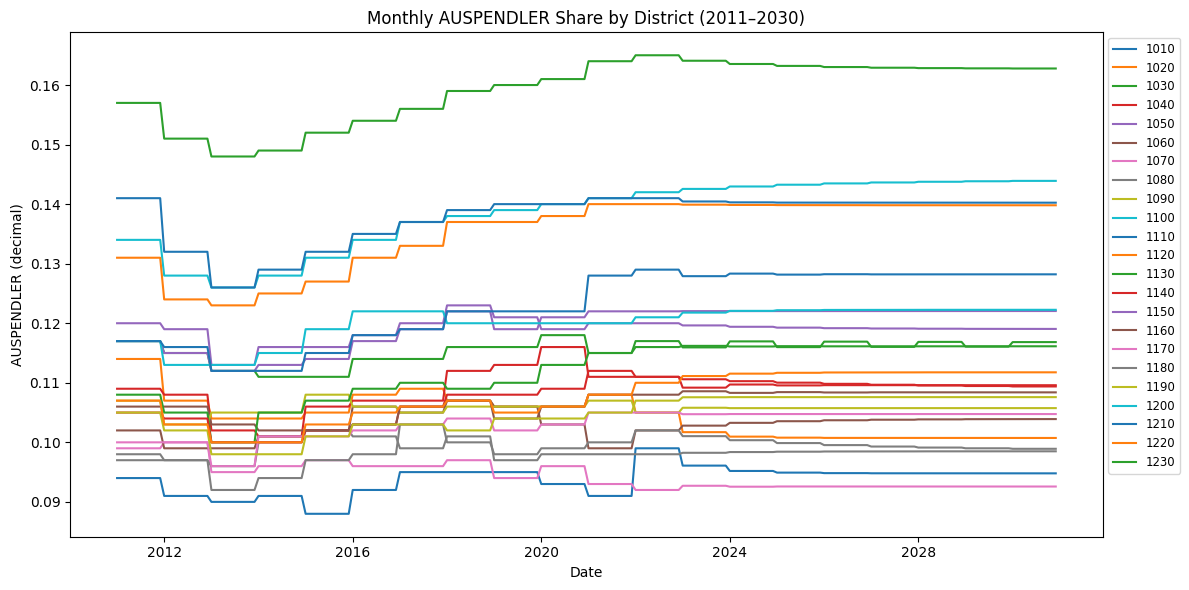

In [14]:
# If erh_monthly_long is not in memory, load the decimal CSV:
erw_monthly_long = pd.read_csv("../data_arima_final/auspendler_by_bezirk.csv", parse_dates=["DATE"])

# Pivot so that each district becomes a column, indexed by DATE, with AUSPENDLER as values
ausp_wide = erw_monthly_long.pivot(index="DATE", columns="BEZIRK", values="AUSPENDLER")

# Plot one line per district
plt.figure(figsize=(12, 6))
for bezirk in ausp_wide.columns:
    plt.plot(ausp_wide.index, ausp_wide[bezirk], label=str(bezirk))

plt.title("Monthly AUSPENDLER Share by District (2011–2030)")
plt.xlabel("Date")
plt.ylabel("AUSPENDLER (decimal)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
plt.tight_layout()
plt.show()
